In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [10]:
# Load the dataset
# Download "uber.csv" from the specified Kaggle dataset and ensure it's in the same directory
dataset_path = "uber.csv"  
data = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print(data.head())

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

In [11]:
# 1. Pre-process the dataset
# Convert 'pickup_datetime' to datetime format
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')

# Drop rows with NaT in 'pickup_datetime' due to conversion issues
data.dropna(subset=['pickup_datetime'], inplace=True)

# Extract date features
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour
data['minute'] = data['pickup_datetime'].dt.minute

# Drop unnecessary columns
data.drop(['pickup_datetime'], axis=1, inplace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Convert categorical columns to numerical (avoid treating latitude/longitude as categorical)
data = pd.get_dummies(data, columns=[])

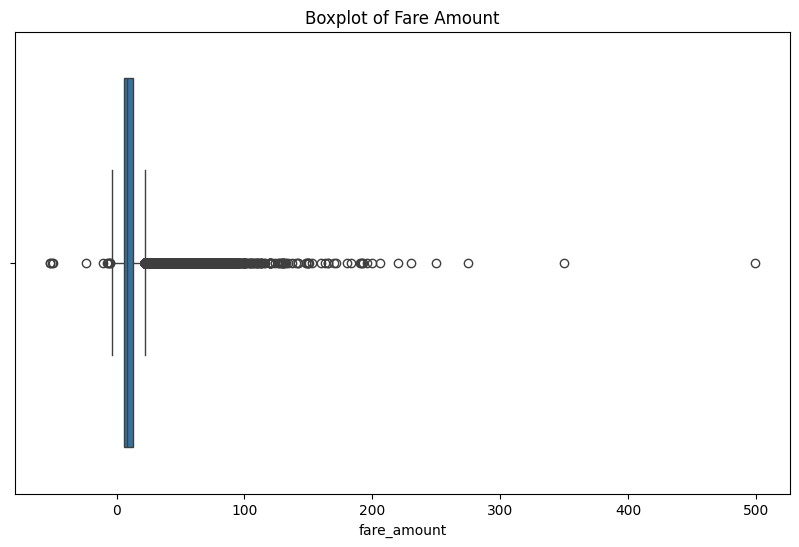

In [12]:

# 2. Identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['fare_amount'])
plt.title('Boxplot of Fare Amount')
plt.show()

# Remove outliers
q1 = data['fare_amount'].quantile(0.25)
q3 = data['fare_amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data = data[(data['fare_amount'] >= lower_bound) & (data['fare_amount'] <= upper_bound)]

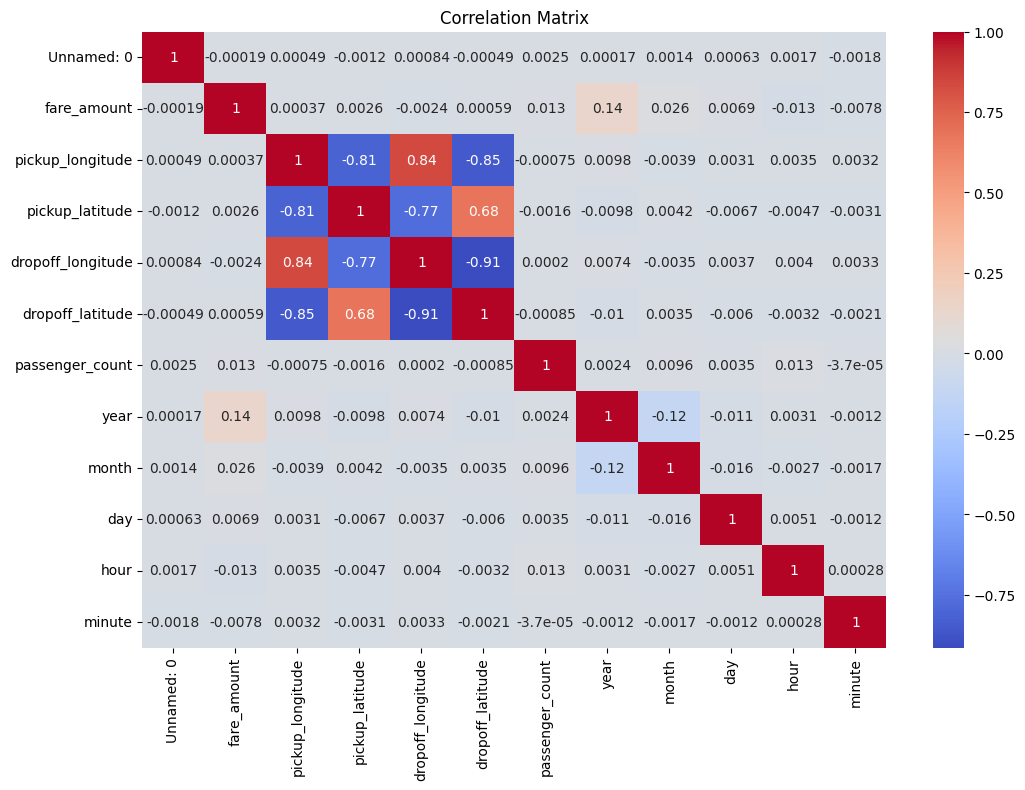

In [15]:
# 3. Check the correlation
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [17]:
# Define features and target variable
X = data.drop('fare_amount', axis=1)
y = data['fare_amount']

# Select only numeric columns for X to avoid issues with StandardScaler
X = X.select_dtypes(include=[np.number])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Initialize the models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# Train the models
linear_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)
lasso_model.fit(X_train_scaled, y_train)

# Predict using the models
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_ridge = ridge_model.predict(X_test_scaled)
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [19]:
# 5. Evaluate the models and compare their respective scores
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

r2_linear, rmse_linear = evaluate_model(y_test, y_pred_linear)
r2_ridge, rmse_ridge = evaluate_model(y_test, y_pred_ridge)
r2_lasso, rmse_lasso = evaluate_model(y_test, y_pred_lasso)

print(f'Linear Regression: R² = {r2_linear:.2f}, RMSE = {rmse_linear:.2f}')
print(f'Ridge Regression: R² = {r2_ridge:.2f}, RMSE = {rmse_ridge:.2f}')
print(f'Lasso Regression: R² = {r2_lasso:.2f}, RMSE = {rmse_lasso:.2f}')

Linear Regression: R² = 0.02, RMSE = 4.11
Ridge Regression: R² = 0.02, RMSE = 4.11
Lasso Regression: R² = 0.02, RMSE = 4.12
